# **리뷰 데이터 감성 분석**

상품 및 서비스, 기관, 단체, 사회적 이슈, 사건 등에 관해서 소셜미디어에 남긴 의견을 수집하고 분석해서 사람들의 감성의 상태 및 태도에 대한 변화, 평가, 선호도 등을 파악하는 빅 데이터 기술

In [1]:
pip install tensorflow

In [2]:
pip install keras

In [3]:
pip install scikit-learn

In [4]:
pip install nltk

In [5]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 50.5 MB/s eta 0:00:00


In [6]:
pip install pandas

In [7]:
pip install matplotlib

In [8]:
### import
import pickle
import pandas as pd
import numpy as np
import re
import tqdm
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [11]:
# 데이터 로드

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [12]:
print('훈련용 리뷰 개수 :', len(train_data))
print(train_data[:5]) # 상위 5개 출력
print('테스트용 리뷰 개수 :', len(test_data))
print(test_data[:5])  # 상위 5개 출력

훈련용 리뷰 개수 : 150000
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
테스트용 리뷰 개수 : 50000
        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0


# 데이터 정제

In [15]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), test_data['document'].nunique()

(146182, 49157)

In [16]:
# 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 개수 :', len(train_data))

총 샘플의 개수 : 146183


<Axes: >

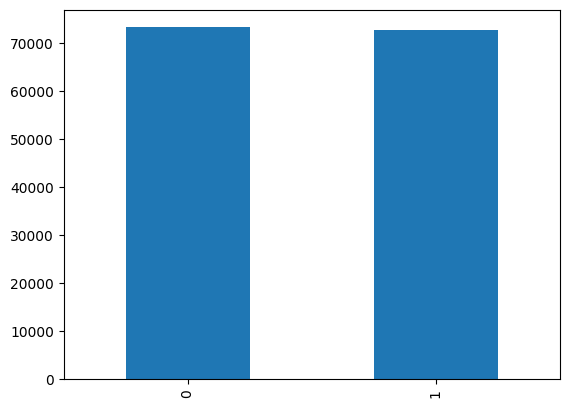

In [18]:
train_data['label'].value_counts().plot(kind='bar')

In [19]:
# 정확한 개수 출력
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


In [32]:
# 비어있는 값(NULL)이 있는지 확인
print(train_data.isnull().sum())

# NULL 이 어느 열에 존재 하는지 확인 -> 몇번째 인덱스인지?
train_data.loc[train_data.document.isnull()]

id            0
document    789
label         0
dtype: int64


id document  label
404      4221289      NaN      0
412      9509970      NaN      1
470     10147571      NaN      1
584      7117896      NaN      0
593      6478189      NaN      0
...          ...      ...    ...
149309   6715725      NaN      1
149358   6780491      NaN      0
149364   8014701      NaN      1
149630   3508604      NaN      0
149773   9233162      NaN      0

[789 rows x 3 columns]

In [34]:
train_data = train_data.dropna(how='any') # NULL 이 존재하는 행 제거
print(train_data.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
149995  False     False  False
149996  False     False  False
149997  False     False  False
149998  False     False  False
149999  False     False  False

[145393 rows x 3 columns]>


In [35]:
# 제거 후 샘플 개수 최종 확인
print(len(train_data))

145393


# **데이터 전처리**

In [36]:
# 한글이랑 띄워쓰기 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]','')
train_data[:5]

<ipython-input-36-a88ffe474ebd>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]','')


id                                           document  label
0   9976970                                  아 더빙 진짜 짜증나네요 목소리      0
1   3819312                         흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                          교도소 이야기구먼 솔직히 재미는 없다평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...      1

In [37]:
# NUll 변경, 존재 확인
train_data['document'] = train_data['document'].str.replace('^ +', '')  # whilte space를 empty 데이터로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


<ipython-input-37-3e8f13aa058b>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', '')  # whilte space를 empty 데이터로 변경


In [38]:
train_data.loc[train_data.document.isnull()][:10]

Empty DataFrame
Columns: [id, document, label]
Index: []

In [39]:
train_data = train_data.dropna(how='any')
print(len(train_data))

145393


In [40]:
# 테스트 데이터에 동일한 전처리 진행
test_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
test_data['document'] = test_data['document'].str.replace('^ +', '')  # 공백 -> emp
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 데이터 개수 :', len(test_data))

전처리 후 테스트용 데이터 개수 : 48852


<ipython-input-40-7b40c3c36162>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
<ipython-input-40-7b40c3c36162>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', '')  # 공백 -> emp


# 토큰화

토큰화 과정에서 불용어 제거 - 보편화된 불용어를 사용해도 무방하지만 우리가 다루고자 하는 데이터를 지속적으로 검토하면서 추가하는 경우가 대부분이다.

In [41]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '걍', '잘', '과', '도', '를',
             '으로', '자', '에', '와', '한', '하다']

In [44]:
okt = Okt()
okt.morphs('와 이런것도 영화라고 차라리 뮤직비디오가 나을 뻔', stem=True)

['오다', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '가', '나다', '뻔']

In [45]:
# 불용어를 제거하고 x_train 이라는 리스트에 넣어주는 작업
from tqdm import tqdm

X_train = [] # 채워줄 빈 리스트 생성
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence)
  stopwords_remove_sentence = [word for word in tokenized_sentence if not word in stopwords]  # 불용어 제거 코드
  X_train.append(stopwords_remove_sentence)

print(X_train[:5])

100%|██████████| 145393/145393 [11:10<00:00, 216.87it/s]

[['아', '더빙', '진짜', '짜증나네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나'], ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스런', '연기', '돋보였던', '영화', '스파이더맨', '에서', '늙어', '보이기만', '했던', '커스틴', '던스트', '너무나도', '이뻐', '보였다']]


In [46]:
# 테스트 데이터에 토큰화, 불용어 제거 진행
X_test = []

for sentence in tqdm(test_data['document']):
  tokenized_sentence = okt.morphs(sentence)
  stopwords_remove_sentence = [word for word in tokenized_sentence if not word in stopwords]
  X_test.append(stopwords_remove_sentence)

print(X_test[:5])

100%|██████████| 48852/48852 [04:15<00:00, 191.07it/s]

[['굳', 'ㅋ'], ['뭐', '야', '평점', '나쁘진', '않지만', '점', '짜', '리', '더', '더욱', '아니잖아'], ['지루하지는', '않은데', '완전', '막장', '임', '돈', '주고', '보기', '에는'], ['만', '아니었어도', '별', '다섯', '개', '줬을텐데', '왜', '로', '나와서', '제', '심기', '불편하게', '하죠'], ['음악', '주가', '된', '최고', '음악', '영화']]


# 정수 인코딩

1. 토큰화가 진행되고 난 다음에 떨어지는 모든 단어에 각자 고유의 번호(정수)를 붙여준다.
2. 각 정수는 데이터에서 등장 빈도수가 높은 순서대로 부여가 된다. -> 인덱스 숫자가 큰 단어들은 빈도수가 낮다.
3. 등장 빈도수가 3회 미만인 단어들이 우리데이터에서 얼마나 비중을 차지하는지 확인하고 제거를 진행하도록 한다.


In [47]:
# 훈련 데이터에서 단어 집합을 생성

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'영화': 1, '을': 2, '너무': 3, '다': 4, '정말': 5, '적': 6, '만': 7, '진짜': 8, '로': 9, '점': 10, '에서': 11, '연기': 12, '것': 13, '평점': 14, '내': 15, '최고': 16, '그': 17, '나': 18, '안': 19, '인': 20, '이런': 21, '스토리': 22, '생각': 23, '못': 24, '왜': 25, '드라마': 26, '게': 27, '이다': 28, '감동': 29, '사람': 30, '보고': 31, '하는': 32, '하고': 33, '말': 34, '고': 35, '더': 36, '배우': 37, '때': 38, 'ㅋㅋ': 39, '아': 40, '감독': 41, '거': 42, '그냥': 43, '본': 44, '요': 45, '재미': 46, '시간': 47, '내용': 48, '까지': 49, '뭐': 50, '중': 51, '보다': 52, '없는': 53, '쓰레기': 54, '수': 55, '네': 56, '지': 57, '봤는데': 58, '작품': 59, '사랑': 60, '할': 61, '하나': 62, '다시': 63, '없다': 64, '볼': 65, '마지막': 66, '좋은': 67, '이건': 68, '정도': 69, '저': 70, '같은': 71, '완전': 72, '입니다': 73, '있는': 74, 'ㅋ': 75, 'ㅠㅠ': 76, '처음': 77, 'ㅋㅋㅋ': 78, '장면': 79, '액션': 80, '주인공': 81, '걸': 82, '이렇게': 83, '보는': 84, '개': 85, '하': 86, '최악': 87, '돈': 88, '이야기': 89, '지금': 90, '봐도': 91, '느낌': 92, '참': 93, '임': 94, '연출': 95, 'ㅡㅡ': 96, '라': 97, '인데': 98, '없고': 99, '듯': 100, '끝': 101, '명작': 102, '그리고': 103, '년':

In [52]:
threshold = 3

total_cnt = len(tokenizer.word_index)   # 총 단어의 수
rare_cnt = 0    # 등장 빈도수가 3보다 작은 단어의 수
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0   # 등장 빈도수가 3보다 작은 단어의 등장 빈도수 총합

# 단어와 빈도수의 쌍을 key와 value로 받아본다.
import time
for key, value in tokenizer.word_counts.items():  # items() : 결과값을 쌍으로 반환해주는 함수
  #print(key, value)
  total_freq = total_freq + value
  # print(total_freq)
  # time.sleep(1)

  if(value < threshold):    # 등장 빈도수가 3보다 작을 때
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합의 크기 :', total_cnt)
print('등장 빈도가 %s 번 이하인 희귀 단어의 수 : %s' %(threshold -1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 :', (rare_cnt/total_cnt)*100, '%')
print('전체 등장 빈도에서 희귀 단어의 빈도 비율 :', (rare_freq/total_freq)*100, '%')



단어 집합의 크기 : 100004
등장 빈도가 2 번 이하인 희귀 단어의 수 : 67691
단어 집합에서 희귀 단어의 비율 : 67.68829246830127 %
전체 등장 빈도에서 희귀 단어의 빈도 비율 : 4.949305773454659 %


결과값을 보아하니 등장 빈도가 2번이하인 단어들은 자연어 처리과정에서 별로 중요하지 않을 수 있다.

In [55]:
# 등장 빈도수가 2 이하인 단어들의 수를 제외한 단어의 개수를 단어 집합 최대 크기로 제한한다.
# 전체 단어 개수 중 빈도가 2 이하인 단어는 제거

vocab_size = total_cnt - rare_cnt + 1 # 0 번을 고려
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 32314


In [57]:
# 32314 를 keras 토크나이저의 인자로 넘겨주고, 텍스트를 정수로 변환

tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train) # 시퀀스로 변환
X_test = tokenizer.texts_to_sequences(X_test) # 테스트도 변환

print(X_train[:5])

[[40, 417, 8, 6598, 624], [905, 419, 31, 567, 1, 182, 1521, 12, 939, 6036, 25784], [357, 2813, 2646, 7326, 12028, 189, 4], [8581, 89, 11210, 205, 46, 64, 14, 4337], [1005, 17, 12, 6409, 1, 2970, 11, 5280, 440, 21847, 1070, 3609, 4526]]


In [70]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

만약에 빈도수가 낮은 단어만으로 구성된 샘플은 빈(empty) 데이터가 되었다는 의미 -> 제거해준다.

---



In [69]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플 제거
X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)
print(len(X_train))
print(len(y_train))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (145393,) + inhomogeneous part.

# 패딩

서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업

리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 10.667528698080375


<function matplotlib.pyplot.show(close=None, block=None)>

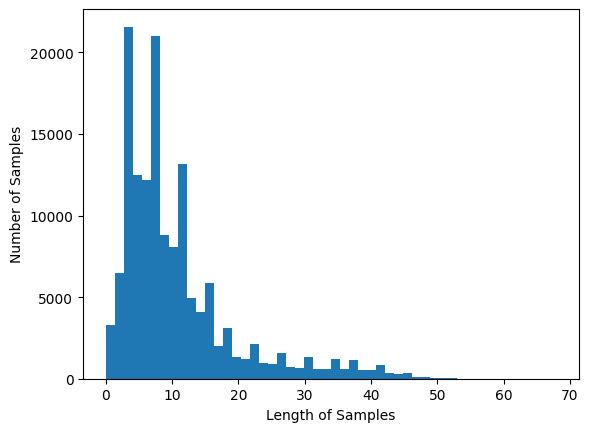

In [72]:
from matplotlib import pyplot as plt
print('리뷰의 최대 길이 :', max(len(review) for review in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins = 50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show